# clover-on-clover connected proton charge radius

In [1]:
import numpy as np
import pandas as pd
import gvar as gv
import lsqfit
import matplotlib.pyplot as plt
%matplotlib notebook
from tqdm import tqdm_notebook as tqdm
import pcr_lib as pcr
import yaml

# switches

In [2]:
switches = dict()
# PLOTTING OPTIONS
switches['plot'] = dict()
switches['plot']['correlator'] = False # data (effective mass, Zs, etc...)
switches['plot']['stability'] = True # correlator stability after fit
# FITTING OPTIONS
switches['fit'] = dict()
switches['fit']['switch'] = True # turn fitting on/off
# choose dataset
switches['fit']['clist']   = ['nucleon','dnucleon','gV','dgV'] # the derivatives should be fit with the correlators or else there's no handel on the parameters
switches['fit']['snk_src'] = ['SS']
switches['fit']['mom']     = [0,1] #,2] # n in 2*n*pi/L
switches['fit']['nstate']  = 2
# time region
switches['fit']['T_3pt']   = [10,14] # t_snk for 3pt: only 10 or 14
switches['fit']['trange'] = dict()
switches['fit']['trange']['nucleon_tmin']   = [4,4] # snk location
switches['fit']['trange']['nucleon_tmax']   = [15,15] # snk location
switches['fit']['trange']['dnucleon_tmin']   = [3,3] # snk location
switches['fit']['trange']['dnucleon_tmax']   = [12,12] # snk location
switches['fit']['trange']['gV_T10_tsym']   = [2,2] # symmetrically drop data: current insertion time
switches['fit']['trange']['gV_T14_tsym']   = [5,5] # current insertion time
switches['fit']['trange']['dgV_T10_tsym']   = [4,4] # current insertion time
switches['fit']['trange']['dgV_T14_tsym']   = [4,4] # current insertion time
# PRIORS
switches['p'] = dict()
# nucleon q = 0
switches['p']['E0_q0'] = gv.gvar(0.7,0.14)
switches['p']['Z0s_q0'] = gv.gvar(2.2E-4,1.1E-4) # z = Z/sqrt(2E)
switches['p']['Z0p_q0'] = gv.gvar(0.0,1.0)
switches['p']['E1_q0'] = gv.gvar(-0.7,0.7) # log splitting to two pions
switches['p']['Z1s_q0'] = gv.gvar(0.0,1.1E-4)
switches['p']['Z1p_q0'] = gv.gvar(0.0,1.0)
# nucleon q = 1
switches['p']['E0_q1'] = gv.gvar(0.75,0.15)
switches['p']['Z0s_q1'] = gv.gvar(2E-4,1E-4)
switches['p']['Z0p_q1'] = gv.gvar(0.0,1.0)
switches['p']['E1_q1'] = gv.gvar(-0.8,1.1) # splitting to zero momentum 2 pion and 1 pion
switches['p']['Z1s_q1'] = gv.gvar(0.0,1E-4)
switches['p']['Z1p_q1'] = gv.gvar(0.0,1.0)
# nucleon q = 2
switches['p']['E0_q2'] = gv.gvar(0.85,0.17)
switches['p']['Z0s_q2'] = gv.gvar(1.6E-4,0.8E-4)
switches['p']['Z0p_q2'] = gv.gvar(0.0,1.0)
switches['p']['E1_q2'] = gv.gvar(-1.0,1.3) # splitting to zero momentum 2 pion and 1 pion
switches['p']['Z1s_q2'] = gv.gvar(0.0,0.8E-4)
switches['p']['Z1p_q2'] = gv.gvar(0.0,1.0)
# dnucleon q = 0 (Y comes before Z... so it's a derivative? something like that)
switches['p']['Y0s_q0'] = gv.gvar(-1.5,1.5) # z' = Z'/[z*sqrt(2E)]
switches['p']['Y0p_q0'] = gv.gvar(0.0,1.0)
switches['p']['Y1s_q0'] = gv.gvar(0.0,1.5)
switches['p']['Y1p_q0'] = gv.gvar(0.0,1.0)
# dnucleon q = 1
switches['p']['Y0s_q1'] = gv.gvar(-1.5,1.5)
switches['p']['Y0p_q1'] = gv.gvar(0.0,1.0)
switches['p']['Y1s_q1'] = gv.gvar(0.0,1.5)
switches['p']['Y1p_q1'] = gv.gvar(0.0,1.0)
# dnucleon q = 2
switches['p']['Y0s_q2'] = gv.gvar(-1.5,1.5)
switches['p']['Y0p_q2'] = gv.gvar(0.0,1.0)
switches['p']['Y1s_q2'] = gv.gvar(0.0,1.5)
switches['p']['Y1p_q2'] = gv.gvar(0.0,1.0)
# gV q = 0
switches['p']['V00_q0'] = gv.gvar(1.25,1.25)
switches['p']['V10_q0'] = gv.gvar(0.0,1.25)
switches['p']['V11_q0'] = gv.gvar(0.0,1.25)
# gV q = 1
switches['p']['V00_q1'] = gv.gvar(1.0,1.0)
switches['p']['V10_q1'] = gv.gvar(0.0,1.0)
switches['p']['V11_q1'] = gv.gvar(0.0,1.0)
# gV q = 2
switches['p']['V00_q2'] = gv.gvar(0.6,0.6)
switches['p']['V10_q2'] = gv.gvar(0.0,0.6)
switches['p']['V11_q2'] = gv.gvar(0.0,0.6)
# dgV q = 0
switches['p']['U00_q0'] = gv.gvar(-5,5)
switches['p']['U10_q0'] = gv.gvar(0.0,5)
switches['p']['U11_q0'] = gv.gvar(0.0,5)
# dgV q = 1
switches['p']['U00_q1'] = gv.gvar(-5,5)
switches['p']['U10_q1'] = gv.gvar(0.0,5)
switches['p']['U11_q1'] = gv.gvar(0.0,5)
# dgV q = 2
switches['p']['U00_q2'] = gv.gvar(-5,5)
switches['p']['U10_q2'] = gv.gvar(0.0,5)
switches['p']['U11_q2'] = gv.gvar(0.0,5)

# read csv file into dataframe
## ensemble information
+ 0.12fm lattice spacing
+ pion mass 400 MeV
+ isoclover

## configuration information
+ 1000 to 2950 skip 10 (196 configurations)
    + configuration 1470 is missing for baryon 2pt tsrc 48, idx = 47
+ two point correlation function
    + `bar_s22_SS_tsrc_[0,48].dat.[re,im]`
    + two sources at `[0,48]`
    + each line contains:
        + individual momentum `[0,1,-1,2,-2]`
        + individual time slice
        + array of z-dependence
        + *e.g.* `bar_s22_S0src_S0_px0_py0_pz0_t0_re`
+ three point correlation function
    + `barff_s22_SS_g8_T[10,14]_tsrc_[0,48].dat.[re,im]`
    + `g8` corresponds to the `V4` current insertion
    + `T[10,14]` is snk location
    + two sources at `[0,48]`
    + each line contains:
        + individual momentum transfer (snk at zero momentum) `[0,1,-1,2,-2]`
        + individual time slice
        + array of z-dependence at current insertion
        + *e.g.* `barff_s2_S0src_S0snk_T10_px0_py0_pz0_g8_t0_re`

## strategy
+ read zero momentum spatial correlator
+ perform source average
+ construct two and three point (with momentum transfer)
+ construct moment correlators

## notes
+ read SS src snk

In [3]:
zdata = pcr.read_csv(switches)

2pt: bar_s22_S0src_S0_px0_py0_pz0_re (195, 96, 32)
3pt: barff_s2_S0src_S0snk_T10_px0_py0_pz0_g8_re (195, 96, 32)
3pt: barff_s2_S0src_S0snk_T14_px0_py0_pz0_g8_re (195, 96, 32)


# construct two and three point correlators
+ Lattice 2016 proceedings @ https://arxiv.org/pdf/1610.02354.pdf
+ project to definite momentum

In [4]:
data = dict()
# two point correlation function
if 'nucleon' in switches['fit']['clist']:
    for snk_src in switches['fit']['snk_src']:
        snk = snk_src[0]
        src = snk_src[1]
        for n in switches['fit']['mom']:
            k = 2.*np.pi*n/32
            pos = zdata['bar_s22_%s0src_%s0_px0_py0_pz0_re' %(src,snk)]*np.cos(k*np.arange(32))
            neg = zdata['bar_s22_%s0src_%s0_px0_py0_pz0_re' %(src,snk)]*np.cos(-k*np.arange(32))
            data['nucleon_%s_q%s' %(str(snk_src),str(n))] = np.sum((pos+neg)/2,axis=2) # mom avg & project to 3 momentum
# gV correlation function
if 'gV' in switches['fit']['clist']:
    for snk_src in switches['fit']['snk_src']:
        snk = snk_src[0]
        src = snk_src[1]
        for n in switches['fit']['mom']:
            k = 2.*np.pi*n/32
            for T in switches['fit']['T_3pt']:
                pos = zdata['barff_s2_%s0src_%s0snk_T%s_px0_py0_pz0_g8_re' %(src,snk,str(T))]*np.cos(k*np.arange(32))
                neg = zdata['barff_s2_%s0src_%s0snk_T%s_px0_py0_pz0_g8_re' %(src,snk,str(T))]*np.cos(-k*np.arange(32))
                data['gV_%s_T%s_q%s' %(str(snk_src),str(T),str(n))] = np.sum((pos+neg)/2,axis=2) # mom avg & project to 3 momentum
data.keys()

dict_keys(['nucleon_SS_q0', 'nucleon_SS_q1', 'gV_SS_T10_q0', 'gV_SS_T14_q0', 'gV_SS_T10_q1', 'gV_SS_T14_q1'])

# construct moments of correlation functions

In [5]:
# two point moment data
z = np.roll(np.arange(32)-15,17)
rz2 = z**2
# apply moment
# output is Ncf * T * Z
if 'dnucleon' in switches['fit']['clist']:
    for q in switches['fit']['mom']:
        for snk_src in switches['fit']['snk_src']:
            snk = snk_src[0]
            src = snk_src[1]
            if q == 0:
                D = -0.5*rz2
            else:
                k = 2.*np.pi*q/32
                D = -z/(2.*k)*np.sin(k*np.arange(32))
            if 'dnucleon' in switches['fit']['clist']:
                temp = D*zdata['bar_s22_%s0src_%s0_px0_py0_pz0_re' %(src,snk)]
                # UNCOMMENT TO PLOT Z DEPENDENCE
                #pcr.plot_2pt_z(temp,title='2pt') #title='dnucleon_%s_q%s' %(snk_src,str(q)))
                # project to 3 momentum
                data['dnucleon_%s_q%s' %(snk_src,str(q))] = np.sum(temp,axis=2)
            if 'dgV' in switches['fit']['clist']:
                for T in switches['fit']['T_3pt']:
                    temp = D*zdata['barff_s2_%s0src_%s0snk_T%s_px0_py0_pz0_g8_re' %(src,snk,str(T))]
                    # UNCOMMENT TO PLOT Z DEPENDENCE
                    #pcr.plot_3pt_z(temp,title='3pt') #title='dgV_%s_T%s_q%s' %(snk_src,str(T),str(q)))
                    # project 3 momentum
                    data['dgV_%s_T%s_q%s' %(snk_src,str(T),str(q))] = np.sum(temp,axis=2)
print(data.keys())

dict_keys(['nucleon_SS_q0', 'nucleon_SS_q1', 'gV_SS_T10_q0', 'gV_SS_T14_q0', 'gV_SS_T10_q1', 'gV_SS_T14_q1', 'dnucleon_SS_q0', 'dgV_SS_T10_q0', 'dgV_SS_T14_q0', 'dnucleon_SS_q1', 'dgV_SS_T10_q1', 'dgV_SS_T14_q1'])


# construct correlated dataset

In [6]:
gvdata = gv.dataset.avg_data(data)
for k in gvdata.keys():
    print(k,np.shape(gvdata[k]))

nucleon_SS_q0 (96,)
nucleon_SS_q1 (96,)
gV_SS_T10_q0 (96,)
gV_SS_T14_q0 (96,)
gV_SS_T10_q1 (96,)
gV_SS_T14_q1 (96,)
dnucleon_SS_q0 (96,)
dgV_SS_T10_q0 (96,)
dgV_SS_T14_q0 (96,)
dnucleon_SS_q1 (96,)
dgV_SS_T10_q1 (96,)
dgV_SS_T14_q1 (96,)


# plot correlation function

In [7]:
dat2name = [i for i in gvdata.keys() if i.split('_')[0] in ['nucleon']]
datd2name = [i for i in gvdata.keys() if i.split('_')[0] in ['dnucleon']]
dat3name = [i for i in gvdata.keys() if i.split('_')[0] in ['gV']]
datd3name = [i for i in gvdata.keys() if i.split('_')[0] in ['dgV']]

if switches['plot']['correlator']:
    # plot effective mass correlator
    fig = plt.figure('meff',figsize=(7,4.326237))
    ax = plt.axes([0.15,0.15,0.8,0.8])
    x = np.arange(2,18)
    for d in dat2name:
        meff = np.log(gvdata[d]/np.roll(gvdata[d],-1))[x]
        ax.errorbar(x,y=[i.mean for i in meff],yerr=[i.sdev for i in meff],label=d)
    ax.legend()
    plt.draw()
    # plot scaled two point correlator
    x = np.arange(2,18)
    for d in dat2name:
        snk_src = d.split('_')[1]
        if snk_src in ['SS','PP']:
            fit = plt.figure('%s scaled correlator' %snk_src,figsize=(7,4.326237))
            ax = plt.axes([0.15,0.15,0.8,0.8])
            meff = np.log(gvdata[d]/np.roll(gvdata[d],-1))
            scor = np.sqrt(gvdata[d]*np.exp(meff*np.arange(len(meff))))[x]
            ax.errorbar(x,y=[i.mean for i in scor],yerr=[i.sdev for i in scor],label=d)
        else:
            pass
    ax.legend()
    plt.draw()
    # plot two point slope
    x = np.arange(2,18)
    for dd in datd2name:
        snk_src = dd.split('_')[1]
        d = dd[1:] # two point name (take out derivative)
        if snk_src in ['SS','PP']:
            fit = plt.figure('%s two point slope' %snk_src,figsize=(7,4.326237))
            ax = plt.axes([0.15,0.15,0.8,0.8])
            meff = np.log(gvdata[d]/np.roll(gvdata[d],-1))
            scor = np.sqrt(gvdata[d]*np.exp(meff*np.arange(len(meff))))
            dcor = ((gvdata[dd]/gvdata[d]+0.5/meff**2+0.5*np.arange(len(meff))/meff)*0.5)[x]
            ax.errorbar(x,y=[i.mean for i in dcor],yerr=[i.sdev for i in dcor],label=dd)
        else:
            pass
    ax.legend()
    plt.draw()
    # plot three point correlator
    x = np.arange(0,16)
    for d in dat3name:
        snk_src = d.split('_')[1]
        Tx = d.split('_')[2]
        T = int(Tx[1:])
        qx = d.split('_')[3]
        q = int(qx[1:])
        if snk_src in ['SS','PP']:
            d2 = d.replace('gV','nucleon').replace('_%s' %Tx,'') # two point correlator name
            d20 = d2.replace(qx,'q0') # zero momentum two point name
            Tlist = np.arange(len(gvdata[d2]))
            Esnk = np.mean(np.log(gvdata[d20]/np.roll(gvdata[d20],-1))[6:9]) # sink is always at zero momentum
            Esrc = np.mean(np.log(gvdata[d2]/np.roll(gvdata[d2],-1))[6:9])
            Zsnk = np.mean(np.sqrt(gvdata[d20]*np.exp(Esnk*Tlist))[6:9]) # sink is always at zero momentum
            Zsrc = np.mean(np.sqrt(gvdata[d2]*np.exp(Esrc*Tlist))[6:9])
            fig = plt.figure('%s gV correlator' %snk_src,figsize=(7,4.326237))
            ax = plt.axes([0.15,0.15,0.8,0.8])
            tlist = np.arange(len(gvdata[d]))
            geff = (gvdata[d]*np.exp(Esnk*T)*np.exp((Esrc-Esnk)*tlist)/(Zsnk*Zsrc))[x]
            ax.errorbar(x+0.1*q,y=[i.mean for i in geff],yerr=[i.sdev for i in geff],label=d,capsize=4,marker='o')
            ax.legend()
    # plot three point derivative correlator
    x = np.arange(0,10)
    for dd in datd3name:
        d = dd[1:] # three point correlator name
        snk_src = dd.split('_')[1]
        Tx = dd.split('_')[2]
        T = int(Tx[1:])
        qx = dd.split('_')[3]
        q = int(qx[1:])
        if snk_src in ['SS','PP']:
            d2 = d.replace('gV','nucleon').replace('_%s' %Tx,'') # two point correlator name
            dd2 = 'd%s' %d2 # two point derivative name
            Tlist = np.arange(len(gvdata[d2]))
            Esrc = np.log(gvdata[d2]/np.roll(gvdata[d2],-1))
            Zsrc = np.sqrt(gvdata[d2]*np.exp(Esrc*Tlist))
            dZsrc = ((gvdata[dd2]/gvdata[d2]+0.5/Esrc**2+0.5*np.arange(len(Esrc))/Esrc)*0.5)
            Emean = np.mean(Esrc[6:9])
            dZmean = np.mean(dZsrc[6:9])
            fig = plt.figure('%s gV derivative correlator' %snk_src,figsize=(7,4.326237))
            ax = plt.axes([0.15,0.15,0.8,0.8])
            tlist = np.arange(len(gvdata[d]))
            dgeff = (gvdata[dd]/gvdata[d]-dZmean+0.5/Emean**2+0.5*tlist/Emean)[x]
            ax.errorbar(x+0.1*q,y=[i.mean for i in dgeff],yerr=[i.sdev for i in dgeff],label=d,capsize=4,marker='o')
            ax.legend()
    plt.draw()

# fit correlators
+ blahblah... I'm too lazy for this... I will regret it later

In [12]:
# instantiate fitter
fitter = pcr.fitter_class(switches['fit']['clist'],switches['fit']['snk_src'],switches['fit']['mom'],switches['fit']['nstate'])
# get priors
p = fitter.p(switches)
print(p)
# result
result = dict()
# loop over t-range
nucleon_tmin = switches['fit']['trange']['nucleon_tmin']
nucleon_tmax = switches['fit']['trange']['nucleon_tmax']
dnucleon_tmin = switches['fit']['trange']['dnucleon_tmin']
dnucleon_tmax = switches['fit']['trange']['dnucleon_tmax']
gV_T10_tsym = switches['fit']['trange']['gV_T10_tsym']
gV_T14_tsym = switches['fit']['trange']['gV_T14_tsym']
dgV_T10_tsym = switches['fit']['trange']['dgV_T10_tsym']
dgV_T14_tsym = switches['fit']['trange']['dgV_T14_tsym']
for t2min in np.arange(nucleon_tmin[0],nucleon_tmin[1]+1):
    for t2max in np.arange(nucleon_tmax[0],nucleon_tmax[1]+1):
        for dt2min in np.arange(dnucleon_tmin[0],dnucleon_tmin[1]+1):
            for dt2max in np.arange(dnucleon_tmax[0],dnucleon_tmax[1]+1):
                for t3sym10 in np.arange(gV_T10_tsym[0],gV_T10_tsym[1]+1):
                    for t3sym14 in np.arange(gV_T14_tsym[0],gV_T14_tsym[1]+1):
                        for dt3sym10 in np.arange(dgV_T10_tsym[0],dgV_T10_tsym[1]+1):
                            for dt3sym14 in np.arange(dgV_T14_tsym[0],dgV_T14_tsym[1]+1):
                                key = '%s_%s_%s_%s_%s_%s_%s_%s' %(t2min,t2max,dt2min,dt2max,t3sym10,t3sym14,dt3sym10,dt3sym14)
                                ckey = '%s_%s_%s' %('_'.join(switches['fit']['clist']),'_'.join([str(m) for m in switches['fit']['mom']]),key)
                                trange = dict()
                                trange['nucleon'] = np.arange(t2min,t2max+1)
                                trange['dnucleon'] = np.arange(dt2min,dt2max+1)
                                trange['gV_T10'] = np.arange(t3sym10,11-t3sym10)
                                trange['gV_T14'] = np.arange(t3sym14,15-t3sym14)
                                trange['dgV_T10'] = np.arange(dt3sym10,11-dt3sym10)
                                trange['dgV_T14'] = np.arange(dt3sym14,15-dt3sym14)
                                x = fitter.x(switches,gvdata,trange)
                                y = fitter.y(x,gvdata)
                                try:
                                    infile = open('./cache/%s.yml' %ckey,'r')
                                    p0 = yaml.load(infile)
                                    infile.close()
                                except:
                                    p0 = {k: p[k].mean for k in p.keys()}
                                #print(p0)
                                if switches['fit']['switch']:
                                    fit = lsqfit.nonlinear_fit(data=(x,y),prior=p,p0=p0,fcn=fitter.fit_function,maxit=100000)
                                else:
                                    fit = 'turn fitting on'
                                # write result to cache
                                result[key] = {'fit':fit,'ckey':ckey}
                                with open('./cache/%s.yml' %ckey, 'w') as outfile:
                                    posterior = {k: fit.p[k].mean for k in fit.p.keys()}
                                    yaml.dump(posterior,outfile)
                                

{'E0_q0': 0.70(14), 'Z0s_q0': 0.00022(11), 'E1_q0': -0.70(70), 'Z1s_q0': 0.00000(11), 'E0_q1': 0.75(15), 'Z0s_q1': 0.00020(10), 'E1_q1': -0.8(1.1), 'Z1s_q1': 0.00000(10), 'Y0s_q0': -1.5(1.5), 'Y1s_q0': 0.0(1.5), 'Y0s_q1': -1.5(1.5), 'Y1s_q1': 0.0(1.5), 'V00_q0': 1.2(1.2), 'V10_q0': 0.0(1.2), 'V11_q0': 0.0(1.2), 'V00_q1': 1.0(1.0), 'V10_q1': 0.0(1.0), 'V11_q1': 0.0(1.0), 'U00_q0': -5.0(5.0), 'U10_q0': 0.0(5.0), 'U11_q0': 0.0(5.0), 'U00_q1': -5.0(5.0), 'U10_q1': 0.0(5.0), 'U11_q1': 0.0(5.0)}


# Correlator stability plots

In [13]:
if switches['plot']['stability']:
    # CALCULATE STABILITY DIRECTION
    tlist = []
    for k in result.keys():
        t = [int(i) for i in k.split('_')]
        tlist.append(t)
    plot_selector = np.std(tlist,axis=0)
    # PLOTTING PARAMETERS (for labels, etc...)
    # time range label
    tlabel = ['nucleon tmin','nucleon tmax','dnucleon tmin','dnucleon tmax','gV10 tsym','gV14 tsym','dgV10 tsym','dgV14 tsym']
    # momentum label
    qlabel = dict()
    qlabel[0] = dict()
    qlabel[0]['marker'] = 'o'
    qlabel[0]['color'] = 'black'
    qlabel[1] = dict()
    qlabel[1]['marker'] = '^'
    qlabel[1]['color'] = 'red'
    qlabel[2] = dict()
    qlabel[2]['marker'] = 's'
    qlabel[2]['color'] = 'blue'
    # PLOT
    # plot p-value of fits
    for idx,p in enumerate(plot_selector):
        if p == 0: pass
        else:
            # plot p-value
            fig = plt.figure('p-value (same for all simultaneous fits)',figsize=(7,4.326237))
            ax = plt.axes([0.15,0.15,0.8,0.8])
            for k in result.keys(): # this loops over t range
                x = int(k.split('_')[idx])
                ax.errorbar(x,y=result[k].Q,marker='o',color='black')
            #ax.legend()
    # ground state energy
    for idx,p in enumerate(plot_selector):
        if p == 0: pass
        else:
            fig = plt.figure('E0 %s' %tlabel[idx],figsize=(7,4.326237))
            ax = plt.axes([0.15,0.15,0.8,0.8])
            for k in result.keys(): # this loops over t range
                x = int(k.split('_')[idx])
                for q in switches['fit']['mom']: # loops over momentum
                    y = result[k].p['E0_q%s' %q]
                    ax.errorbar(x,y=y.mean,yerr=y.sdev,marker=qlabel[q]['marker'],color=qlabel[q]['color'],capsize=3,label='E0_q%s' %q)
            #ax.legend()
            plt.show()
    # ground state Z slope
    if 'dnucleon' in switches['fit']['clist']:
        for idx,p in enumerate(plot_selector):
            if p == 0: pass
            else:
                smears = [i.lower() for i in np.unique(list(''.join(switches['fit']['snk_src'])))]
                for s in smears:
                    fig = plt.figure('dZ0%s %s' %(s,tlabel[idx]),figsize=(7,4.326237))
                    ax = plt.axes([0.15,0.15,0.8,0.8])
                    for k in result.keys(): # this loops over t range
                        x = int(k.split('_')[idx])
                        for q in switches['fit']['mom']: # loops over momentum
                            y = result[k].p['Y0%s_q%s' %(s,q)]
                            ax.errorbar(x,y=y.mean,yerr=y.sdev,marker=qlabel[q]['marker'],color=qlabel[q]['color'],capsize=3,label='Y0%s_q%s' %(s,q))
                    #ax.legend()
                    plt.show()
    # ground state matrix element
    if 'gV' in switches['fit']['clist']:
        for idx,p in enumerate(plot_selector):
            if p == 0: pass
            else:
                fig = plt.figure('g00 %s' %tlabel[idx],figsize=(7,4.326237))
                ax = plt.axes([0.15,0.15,0.8,0.8])
                for k in result.keys(): # this loops over t range
                    x = int(k.split('_')[idx])
                    for q in switches['fit']['mom']: # loops over momentum
                        y = result[k].p['V00_q%s' %q]
                        ax.errorbar(x,y=y.mean,yerr=y.sdev,marker=qlabel[q]['marker'],color=qlabel[q]['color'],capsize=3,label='V00_q%s' %q)
    else: pass
    # ground state gV slope
    if 'dgV' in switches['fit']['clist']:
        for idx,p in enumerate(plot_selector):
            if p == 0: pass
            else:
                fig = plt.figure('dg00 %s' %tlabel[idx],figsize=(7,4.326237))
                ax = plt.axes([0.15,0.15,0.8,0.8])
                for k in result.keys(): # this loops over t range
                    x = int(k.split('_')[idx])
                    for q in switches['fit']['mom']: # loops over momentum
                        y = result[k].p['U00_q%s' %q]
                        ax.errorbar(x,y=y.mean,yerr=y.sdev,marker=qlabel[q]['marker'],color=qlabel[q]['color'],capsize=3,label='V00_q%s' %q)
    else: pass

# unpack result to get slopes
overlap = Z_s sqrt(2 E_s) for s in {src,snk}

overlap derivative = Y_s Z_s sqrt(2 E_s) for s in {src,snk}

gV = V 2 sqrt(E_src E_snk)

gV derivative = U 2 V sqrt(E_src E_snk)

In [57]:
for k in result.keys():
    print(result[k]['ckey'])
    print(result[k]['fit'])
    smears = [i.lower() for i in np.unique(list(''.join(switches['fit']['snk_src'])))]
    phys = dict()
    if 'nucleon' in result[k]['ckey'].split('_'):
        phys['Z'] = dict()
        for s in smears:
            phys['Z'][s] = dict()
            for q in switches['fit']['mom']:
                Z = result[k]['fit'].p['Z0%s_q%s' %(s,str(q))]
                E = result[k]['fit'].p['E0_q%s' %str(q)]
                phys['Z'][s][q] = Z*np.sqrt(2*E)
    if 'dnucleon' in result[k]['ckey'].split('_'):
        phys['dZ'] = dict()
        for s in smears:
            phys['dZ'][s] = dict()
            for q in switches['fit']['mom']:
                Y = result[k]['fit'].p['Y0%s_q%s' %(s,str(q))]
                Z = result[k]['fit'].p['Z0%s_q%s' %(s,str(q))]
                E = result[k]['fit'].p['E0_q%s' %str(q)]
                phys['dZ'][s][q] = Y*Z*np.sqrt(2*E)
    if 'gV' in result[k]['ckey'].split('_'):
        phys['gV'] = dict()
        for q in switches['fit']['mom']:
            V = result[k]['fit'].p['V00_q%s' %(str(q))]
            E = result[k]['fit'].p['E0_q%s' %str(q)]
            E0 = result[k]['fit'].p['E0_q0']
            phys['gV'][q] = 2*V*np.sqrt(E*E0)
    if 'dgV' in result[k]['ckey'].split('_'):
        phys['dgV'] = dict()
        for q in switches['fit']['mom']:
            U = result[k]['fit'].p['U00_q%s' %str(q)]
            V = result[k]['fit'].p['V00_q%s' %str(q)]
            E = result[k]['fit'].p['E0_q%s' %str(q)]
            E0 = result[k]['fit'].p['E0_q0']
            phys['dgV'][q] = 2*U*V*np.sqrt(E*E0)
print(phys)

nucleon_dnucleon_gV_dgV_0_1_4_15_3_12_2_5_4_4
Least Square Fit:
  chi2/dof [dof] = 1.2 [88]    Q = 0.11    logGBF = 2370.6

Parameters:
          E0_q0      0.7414 (76)       [    0.70 (14) ]  
         Z0s_q0    0.000207 (11)       [ 0.00022 (11) ]  
          E1_q0       -2.07 (32)       [   -0.70 (70) ]  *
         Z1s_q0   -0.000079 (34)       [ 0.00000 (11) ]  
          E0_q1      0.7678 (73)       [    0.75 (15) ]  
         Z0s_q1    0.000192 (10)       [ 0.00020 (10) ]  
          E1_q1       -2.03 (30)       [   -0.8 (1.1) ]  *
         Z1s_q1    0.000073 (34)       [ 0.00000 (10) ]  
         Y0s_q0       -1.66 (11)       [   -1.5 (1.5) ]  
         Y1s_q0       -0.1 (1.1)       [    0.0 (1.5) ]  
         Y0s_q1       -1.64 (12)       [   -1.5 (1.5) ]  
         Y1s_q1       -0.36 (90)       [    0.0 (1.5) ]  
         V00_q0       1.116 (74)       [    1.2 (1.2) ]  
         V10_q0     -0.0037 (38)       [    0.0 (1.2) ]  
         V11_q0       -0.51 (71)       [    0.0 (1

# plot the result
d/dp^2 is from exp(ipx) so p = 2n pi/L

p^2 is the x axis

<IPython.core.display.Javascript object>


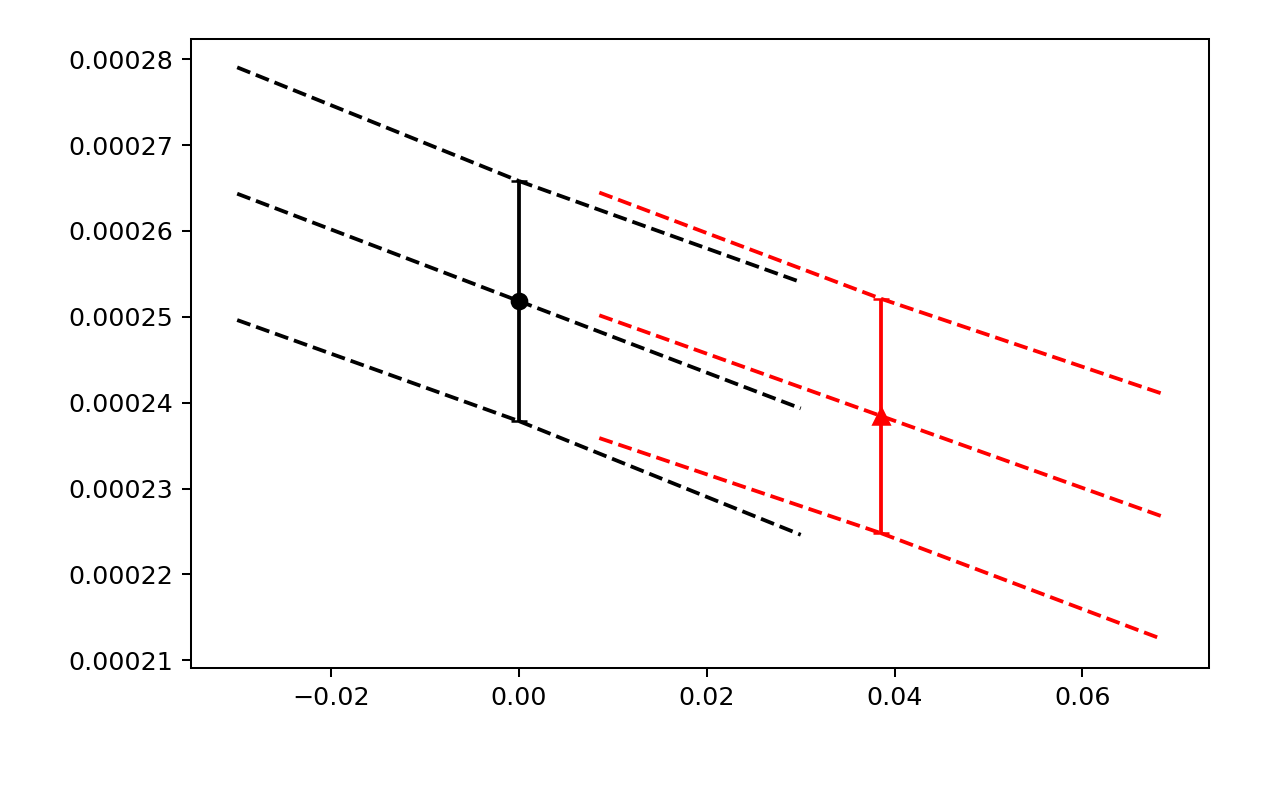

<IPython.core.display.Javascript object>


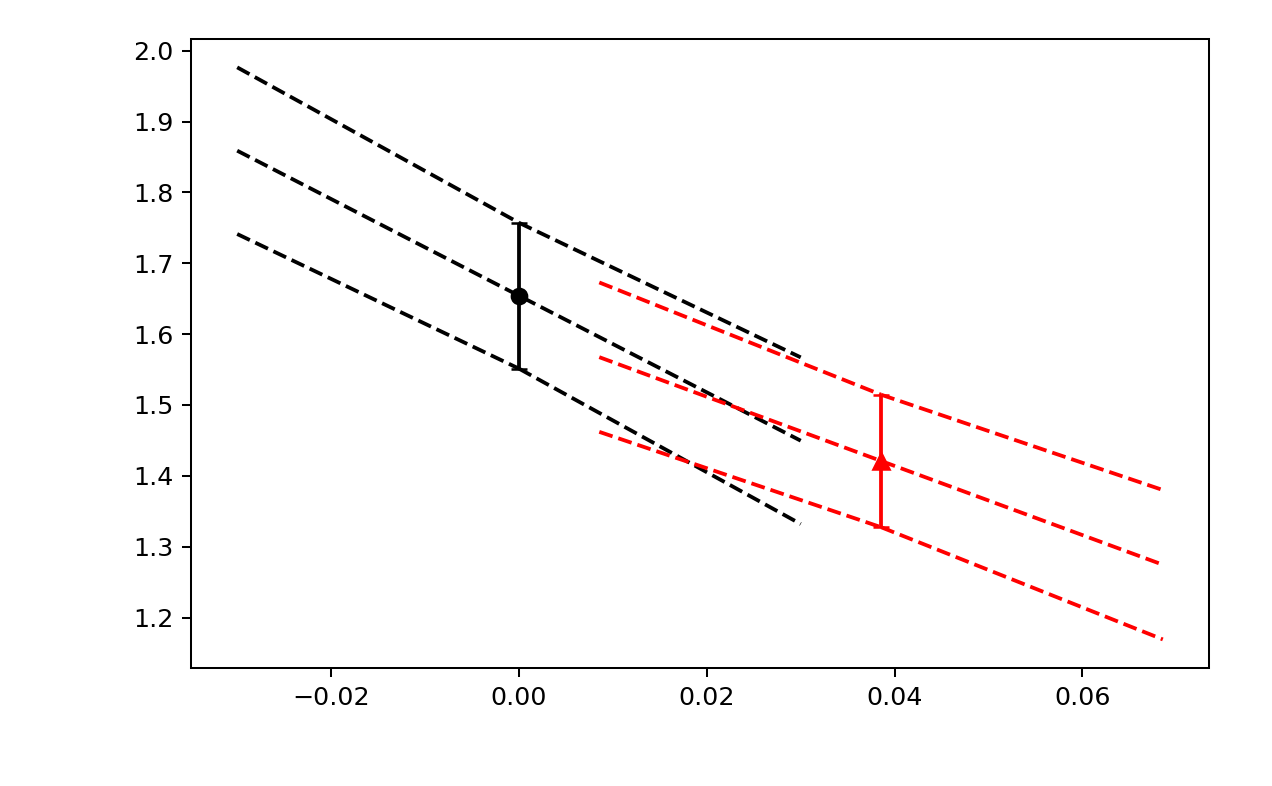

In [62]:
smears = [i.lower() for i in np.unique(list(''.join(switches['fit']['snk_src'])))]
qlabel = dict()
qlabel[0] = dict()
qlabel[0]['marker'] = 'o'
qlabel[0]['color'] = 'black'
qlabel[1] = dict()
qlabel[1]['marker'] = '^'
qlabel[1]['color'] = 'red'
qlabel[2] = dict()
qlabel[2]['marker'] = 's'
qlabel[2]['color'] = 'blue'
slope_l = 0.03
for s in smears:
    if 'nucleon' in switches['fit']['clist']:
        fig = plt.figure('Z%s' %s,figsize=(7,4.326237))
        ax = plt.axes([0.15,0.15,0.8,0.8])
        for n in phys['Z'][s].keys():
            p2 = (2*np.pi*n/32)**2
            Z = phys['Z'][s][n]
            ax.errorbar(x=p2,y=Z.mean,yerr=Z.sdev,color=qlabel[n]['color'],marker=qlabel[n]['marker'],capsize=3)
            try:
                dZ = phys['dZ'][s][n]
                # plot central slope
                x = np.array([p2-slope_l,p2,p2+slope_l])
                slope = Z.mean+dZ.mean*(x-p2)
                ax.errorbar(x=x,y=slope,color=qlabel[n]['color'],marker='None',ls='--')
                # plot right side slope
                xp = np.array([p2,p2+slope_l])
                pp = (Z.mean+Z.sdev)+(dZ.mean+dZ.sdev)*(xp-p2)
                ax.errorbar(x=xp,y=pp,color=qlabel[n]['color'],marker='None',ls='--')
                pm = (Z.mean-Z.sdev)+(dZ.mean-dZ.sdev)*(xp-p2)
                ax.errorbar(x=xp,y=pm,color=qlabel[n]['color'],marker='None',ls='--')
                # plot left side slope
                xm = np.array([p2-slope_l,p2])
                mp = (Z.mean+Z.sdev)+(dZ.mean-dZ.sdev)*(xm-p2)
                ax.errorbar(x=xm,y=mp,color=qlabel[n]['color'],marker='None',ls='--')
                mm = (Z.mean-Z.sdev)+(dZ.mean+dZ.sdev)*(xm-p2)
                ax.errorbar(x=xm,y=mm,color=qlabel[n]['color'],marker='None',ls='--')
            except:
                pass
if 'gV' in switches['fit']['clist']:
    fig = plt.figure('gV',figsize=(7,4.326237))
    ax = plt.axes([0.15,0.15,0.8,0.8])
    for n in phys['gV'].keys():
        p2 = (2*np.pi*n/32)**2
        V = phys['gV'][n]
        ax.errorbar(x=p2,y=V.mean,yerr=V.sdev,color=qlabel[n]['color'],marker=qlabel[n]['marker'],capsize=3)
        try:
            dV = phys['dgV'][n]
            # plot central slope
            x = np.array([p2-slope_l,p2,p2+slope_l])
            slope = V.mean+dV.mean*(x-p2)
            ax.errorbar(x=x,y=slope,color=qlabel[n]['color'],marker='None',ls='--')
            # plot right side slope
            xp = np.array([p2,p2+slope_l])
            pp = (V.mean+V.sdev)+(dV.mean+dV.sdev)*(xp-p2)
            ax.errorbar(x=xp,y=pp,color=qlabel[n]['color'],marker='None',ls='--')
            pm = (V.mean-V.sdev)+(dV.mean-dV.sdev)*(xp-p2)
            ax.errorbar(x=xp,y=pm,color=qlabel[n]['color'],marker='None',ls='--')
            # plot left side slope
            xm = np.array([p2-slope_l,p2])
            mp = (V.mean+V.sdev)+(dV.mean-dV.sdev)*(xm-p2)
            ax.errorbar(x=xm,y=mp,color=qlabel[n]['color'],marker='None',ls='--')
            mm = (V.mean-V.sdev)+(dV.mean+dV.sdev)*(xm-p2)
            ax.errorbar(x=xm,y=mm,color=qlabel[n]['color'],marker='None',ls='--')
        except:
            pass